In [25]:
import pandas as pd
from pathlib import Path

a2_df_census_ol_pejeta_eastern = pd.read_pickle("../data/pkl/a2_df_census_ol_pejeta_eastern.pkl")
a2_df_census_ol_pejeta_eastern_rank = pd.read_pickle("../data/pkl/a2_df_census_ol_pejeta_eastern_rank.pkl")
a2_df_census_ol_pejeta_eastern_rank.head()

Year,2005,2006,2007,2008,2009,2010,2012,2013,2014,2015,2016,2017,2019,2020,2021,2022,2023
Species,,,,,,,,,,,,,,,,,
Baboon troop,16,4,18,18,16,17,14,17,20,17,15,16,17,16,15,9,7
Black rhino,10,11,11,11,12,10,11,11,13,11,13,12,10,8,8,10,9
Buffalo,2,1,1,2,5,3,2,2,2,3,3,3,1,1,1,1,1
Bushbuck,16,17,19,14,16,21,20,20,22,18,18,17,17,18,15,15,17
Cheetah,16,18,19,18,20,21,18,20,22,18,18,17,17,18,17,18,17


In [20]:
import pandas as pd
import numpy as np

summary = a2_df_census_ol_pejeta_eastern.copy()

to_rank = (
    summary
    .drop(index="Column_Total", errors="ignore")
    .drop(columns=["Row_Total"], errors="ignore")
)

ranks_wide = to_rank.rank(axis=0, method='min', ascending=False)

# 1) Reciprocal-rank weights (higher rank -> smaller weight)
recip = (1 / ranks_wide).astype(float).fillna(0)

# 2) Normalize within each year so column weights sum to 1 (makes years comparable)
recip_norm = recip.div(recip.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)

# 3) A cross-year dominance score per species (equal weight to each year)
species_recip_score = recip_norm.mean(axis=1).sort_values(ascending=False)

# Optional: “Borda-like” linear rank weights, also normalised per year
max_rank_per_year = ranks_wide.max(skipna=True)
borda = (max_rank_per_year - ranks_wide + 1)  # top rank gets largest weight
borda_norm = borda.div(borda.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)
species_borda_score = borda_norm.mean(axis=1).sort_values(ascending=False)

borda.head()

Year,2005,2006,2007,2008,2009,2010,2012,2013,2014,2015,2016,2017,2019,2020,2021,2022,2023
Species,,,,,,,,,,,,,,,,,
Baboon troop,1.0,15.0,2.0,1.0,7.0,5.0,7.0,4.0,3.0,2.0,4.0,2.0,1.0,3.0,3.0,10.0,11.0
Black rhino,7.0,8.0,9.0,8.0,11.0,12.0,10.0,10.0,10.0,8.0,6.0,6.0,8.0,11.0,10.0,9.0,9.0
Buffalo,15.0,18.0,19.0,17.0,18.0,19.0,19.0,19.0,21.0,16.0,16.0,15.0,17.0,18.0,17.0,18.0,17.0
Bushbuck,1.0,2.0,1.0,5.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,1.0
Cheetah,1.0,1.0,1.0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [21]:
species_borda_score.head(50)

Species
Buffalo                 0.092680
Impala                  0.092307
Plains zebra            0.090527
Thomson's gazelle       0.078437
Grant's gazelle         0.076508
Warthog                 0.068743
Waterbuck               0.057868
Elephant                0.054853
Hartebeest              0.048556
Black rhino             0.046719
Eland                   0.045227
Giraffe                 0.045182
Southern white rhino    0.034135
Grevy's zebra           0.030354
Baboon troop            0.024962
Oryx                    0.024124
Lion                    0.015490
Jackal                  0.010001
Bushbuck                0.009958
Hyena                   0.009683
Hippo                   0.008877
Reedbuck                0.007830
Wild dog                0.007217
Hybrid zebra            0.007108
Steenbok                0.006343
Cheetah                 0.006312
dtype: float64

In [22]:
# Proportional abundances per year
prop = to_rank.div(to_rank.sum(axis=0).replace(0, np.nan), axis=1)

# Shannon diversity H' and Pielou evenness J' per year
H = -(prop * np.log(prop.replace(0, np.nan))).sum(axis=0)
S = (to_rank > 0).sum(axis=0)                    # richness
J = H / np.log(S.replace(0, np.nan))

# Bray–Curtis dissimilarity needs pairwise comparisons; Spearman rank corr for rank stability:
spearman_by_year = to_rank.corr(method='spearman')  # columns = years
prop.head()

Year,2005,2006,2007,2008,2009,2010,2012,2013,2014,2015,2016,2017,2019,2020,2021,2022,2023
Species,,,,,,,,,,,,,,,,,
Baboon troop,0.000000,0.096931,0.000466,0.000000,0.000630,0.001631,0.002767,0.000741,0.000279,0.000499,0.000881,0.000328,0.000000,0.000446,0.000558,0.011483,0.029029
Black rhino,0.007331,0.005924,0.008384,0.005034,0.004093,0.011415,0.009486,0.012231,0.005297,0.010479,0.005729,0.007864,0.011874,0.018287,0.015067,0.010984,0.025025
Buffalo,0.178152,0.340872,0.221239,0.211175,0.080290,0.152059,0.177470,0.203113,0.235852,0.192615,0.195681,0.160550,0.303647,0.314005,0.458147,0.267599,0.240240
Bushbuck,0.000000,0.000539,0.000000,0.001007,0.000630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000558,0.000499,0.000000
Cheetah,0.000000,0.000000,0.000000,0.000000,0.000315,0.000000,0.000395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [28]:
abund = a2_df_census_ol_pejeta_eastern

In [29]:
def diversity_metrics(abund: pd.DataFrame) -> pd.DataFrame:
    # proportions per year
    col_sums = abund.sum(axis=0)
    prop = abund.div(col_sums.replace(0, np.nan), axis=1)

    # richness (Hill N0)
    S = (abund > 0).sum(axis=0)

    # Shannon (H'), Hill N1 = exp(H')
    H = -(prop * np.log(prop.replace(0, np.nan))).sum(axis=0).fillna(0)
    N1 = np.exp(H)

    # Simpson D = sum p^2, Hill N2 = 1/D
    D = (prop ** 2).sum(axis=0).fillna(0)
    N2 = (1 / D.replace(0, np.nan)).fillna(0)

    # Evenness: Pielou J' and Hill evenness (N1/S)
    J = (H / np.log(S.replace(0, np.nan))).fillna(0)
    E_hill = (N1 / S.replace(0, np.nan)).fillna(0)

    out = pd.DataFrame({
        "Richness_S": S,
        "Shannon_H'": H,
        "Hill_N1": N1,
        "Simpson_D": D,
        "Hill_N2": N2,
        "Pielou_J'": J,
        "Hill_evenness_N1_over_S": E_hill,
        "Total_Abundance": col_sums
    })
    out.index.name = "Year"
    return out

metrics = diversity_metrics(abund)
metrics.round(3).head(50)

,Richness_S,Shannon_H',Hill_N1,Simpson_D,Hill_N2,Pielou_J',Hill_evenness_N1_over_S,Total_Abundance
Year,,,,,,,,
2005,16,1.693,5.433,0.295,3.393,0.610,0.340,2728
2006,18,1.679,5.359,0.297,3.366,0.581,0.298,3714
2007,19,1.723,5.602,0.289,3.455,0.585,0.295,4294
2008,18,1.677,5.349,0.296,3.374,0.580,0.297,7946
2009,22,1.684,5.388,0.297,3.369,0.545,0.245,6352
2010,21,1.761,5.821,0.287,3.480,0.579,0.277,4906
2012,20,1.668,5.303,0.301,3.327,0.557,0.265,5060
2013,20,1.707,5.512,0.295,3.394,0.570,0.276,5396
2014,22,1.711,5.537,0.294,3.400,0.554,0.252,7174


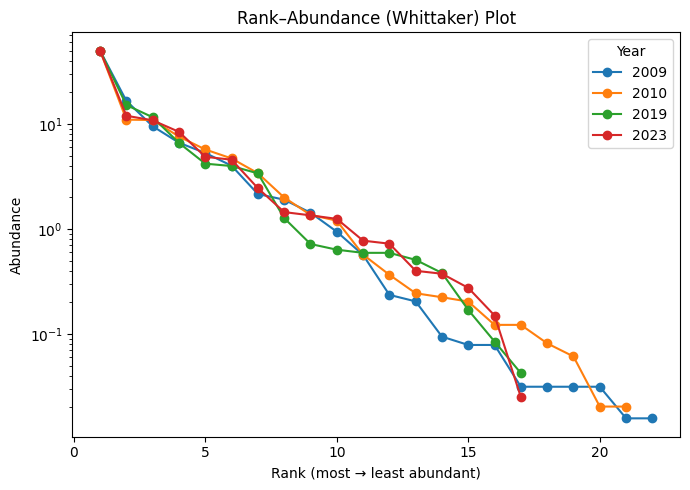

In [37]:
import matplotlib.pyplot as plt

def whittaker_plot(abund: pd.DataFrame, years=None, log_y=True):
    """
    Draws rank–abundance curves. One curve per year.
    """
    if years is None:
        years = list(abund.columns)

    plt.figure(figsize=(7, 5))
    for yr in years:
        s = abund[yr]
        s = s[s > 0].sort_values(ascending=False)  # positive abundances only
        if s.empty:
            continue
        ranks = np.arange(1, len(s) + 1)
        plt.plot(ranks, s.values, marker="o", label=str(yr))

    plt.xlabel("Rank (most → least abundant)")
    plt.ylabel("Abundance")
    if log_y:
        plt.yscale("log")  # classic Whittaker uses log-abundance
    plt.title("Rank–Abundance (Whittaker) Plot")
    plt.legend(title="Year")
    plt.tight_layout()
    plt.show()

# Example: plot a few years (or omit 'years=' to plot all)
#whittaker_plot(abund, years=[2005, 2009, 2017, 2023], log_y=True)
#whittaker_plot(prop*100, years=[2009, 2023], log_y=False)
#whittaker_plot(abund, years=[2008, 2019], log_y=True)
#whittaker_plot(abund, years=[2009, 2010, 2019, 2023], log_y=True)
prop = abund.div(abund.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)
whittaker_plot(prop*100, years=[2009, 2010, 2019, 2023], log_y=True)